In this notebook, we'll load up the exported visit dataset and try to save a sparse matrix with all the categorical variables re-encoded as dummy variables that are suitable for modeling with the `glmnet` package.

In [ ]:
library(glmnet)

Here, we are loading a file that is not included in this repository--as per our IRB protocol, access to our full EMR dataset is restricted to Mount Sinai's network and authorized investigators for this study. However, we provide an example of the format of this data file in `data/exported_visit_data.EXAMPLE.tsv`. **You will need to modify this** to input your own data into this analysis.

All of the figures in these notebooks show the results on our own full dataset.

In [ ]:
df <- read.table('data/exported_visit_data.tsv', sep="\t", quote="", header=TRUE, stringsAsFactors=FALSE)
df$gender <- as.factor(df$gender)
df$age_over89 <- as.factor(df$age_over89)
df$cdtox_pcr_positive <- as.factor(df$cdtox_pcr_positive)
df$cdtox_eia_positive <- as.factor(df$cdtox_eia_positive)
df$started_cdtox_pcr <- as.factor(df$started_cdtox_pcr)
df$cdi_dx <- as.factor(df$cdi_dx)

First, the most naive examination possible; simply plot the distributions of LOS against `cdi_dx`, the presence of the CDI ICD-9 code.

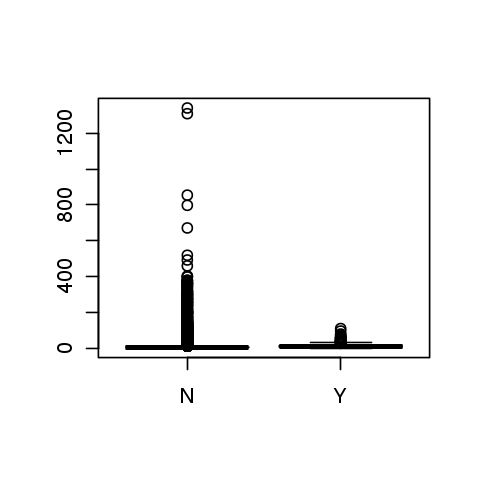

In [24]:
options(jupyter.plot_mimetypes = "image/png") 
options(repr.plot.width=4, repr.plot.height=4)
plot(df$cdi_dx, df$length_of_stay)

Log-scaling the Y-axis will make differences easier to see.

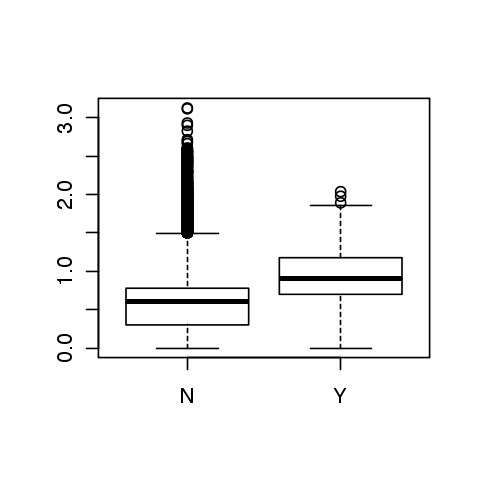

In [25]:
plot(df$cdi_dx, log10(pmax(ceiling(df$length_of_stay), 1)))

There is a weak correlation between `length_of_stay` and `cdi_dx` in the dataset. There is large variation (3 orders of magnitude) in the `length_of_stay` values.

First order of business is to convert factors and the lists of diagnosis codes into matrices of dummy variables appropriate for a linear model, and glue this back on to the numerical data.

We start by building a matrix from the only two numerical variables that we have, `length_of_stay` and `age`.

We log10-scale `length_of_stay` after setting its minimum value to 1 day, because it is unbounded in the positive direction. Note that even though we include it in the matrix in case we want to use it for generalized linear models, we don't actually include it in the propensity models, since you are not supposed to include the outcome values while propensity matching (see [Stuart, *Statistical Science*, 2010](http://biostat.jhsph.edu/~estuart/Stuart10.StatSci.pdf)). We don't do any scaling or clipping when making comparisons on `length_of_stay` as a primary outcome in the matching-based analysis.

We don't need to standardize these variables for `glmnet` if we use `standardize = TRUE` which is the default. See [this thread](https://thinklab.com/discussion/computing-standardized-logistic-regression-coefficients/205) for details on why. Briefly, `glmnet` automatically standardizes (scales and centers) all variables and then when reporting the coefficients it applies the Agresti transformation so they are in the same units as the original input variables.

In [26]:
mat <- cBind(Matrix(log10(pmax(df$length_of_stay, 1)), sparse=TRUE), Matrix(as.numeric(df$age), sparse=TRUE))
colnames(mat) <- c("length_of_stay", "age")
mean(mat[,1])
sd(mat[,1])
mean(mat[,2])
sd(mat[,2])

[1] 0.524811

[1] 0.376747

[1] 53.81304

[1] 19.44602

Now for each covariate factor variable, convert it to a model matrix of dummy variables, and glue it to the right hand side of the matrix.

Note that our dataset included more `gender` values than just "Male" and "Female."

The reason we have an `age_over89` factor variable is because `age` is right-clipped at 89 years to satisfy [HIPAA Safe Harbor](https://www.hhs.gov/hipaa/for-professionals/privacy/special-topics/de-identification/#safeharborguidance) guidelines. This dummy variable allows this property of the data to be properly interpreted by propensity models, although there can only be a uniform effect in the models for all ages above 89.

In [27]:
mat2 <- mat
for (fac in c("gender", "age_over89")) {
    facAsSparse <- t(fac2sparse(df[[fac]]))
    colnames(facAsSparse) <- unname(sapply(colnames(facAsSparse), function(x) { paste0(fac, ":", x) }))
    mat2 <- cBind(mat2, facAsSparse)
}
str(mat2)
colnames(mat2)

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:679684] 1 2 3 4 5 6 7 8 9 10 ...
  ..@ p       : int [1:9] 0 163870 335808 437772 437774 507745 507746 676440 679684
  ..@ Dim     : int [1:2] 171938 8
  ..@ Dimnames:List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:8] "length_of_stay" "age" "gender:Female" "gender:Indeterminant" ...
  ..@ x       : num [1:679684] 0.671 0.588 0.224 0.384 0.662 ...
  ..@ factors : list()


[1] "length_of_stay"       "age"                  "gender:Female"       
[4] "gender:Indeterminant" "gender:Male"          "gender:NOT AVAILABLE"
[7] "age_over89:N"         "age_over89:Y"

And now, for each variable containing a comma-delimited list of codes or tags, we must create matrices of dummy variables for them, and glue them to the right hand side of the matrix.

All the possible codes are saved in tables that are loaded at this point. The actual tables for our dataset are provided as the `data/codelist_*` files. **You will need to modify these** for a different dataset.

In [28]:
adm_sources <- readLines('data/codelist_adm_sources.txt')
dx.df <- read.table('data/codelist_seen_dxs.tsv', sep="\t", quote="", header=TRUE, stringsAsFactors=FALSE)
lab.df <- read.table('data/codelist_lab_result_codes.tsv', sep="\t", quote="", header=TRUE, stringsAsFactors=FALSE)
med.df <- read.table('data/codelist_med_codes.tsv', sep="\t", quote="", header=TRUE, stringsAsFactors=FALSE)
surg.df <- read.table('data/codelist_surgery_procs.tsv', sep="\t", quote="", header=TRUE, stringsAsFactors=FALSE)
dx_codes <- dx.df$code
lab_codes <- lab.df$code
med_codes <- med.df$code
surg_codes <- surg.df$code
str(adm_sources)
str(dx_codes)
str(lab_codes)
str(med_codes)
str(surg_codes)

 chr [1:17] "Emergency Room" "Non Health Care Facility" ...
 chr [1:6362] "188.9" "584.5" "174.9" "211.3" "255.10" "272.4" ...
 chr [1:1488] "8427-ABS NATURAL KILLER" "5410-DER. FERINAE IGE" ...
 int [1:7529] 54501 7045 12206 16568 74201 73370 64352 6839 42319 97736 ...
 chr [1:1035] "DEEP BRAIN STIM LEAD PLACEMENT- BILATERAL" ...


Create a mapping of `dx_codes`, `lab_codes`, and `med_codes` to column indices.

In [29]:
adm_sourcesToCol <- 1:length(adm_sources)
names(adm_sourcesToCol) <- adm_sources

dx_codesToCol <- 1:length(dx_codes)
names(dx_codesToCol) <- dx_codes

lab_codesToCol <- 1:length(lab_codes)
names(lab_codesToCol) <- lab_codes

med_codesToCol <- 1:length(med_codes)
names(med_codesToCol) <- med_codes

surg_codesToCol <- 1:length(surg_codes)
names(surg_codesToCol) <- surg_codes

codesToCols <- list(admission_sources=adm_sourcesToCol,
                    problem_list=dx_codesToCol, 
                    surgery_cases=surg_codesToCol,
                    meds_reported=med_codesToCol,
                    meds_administered=med_codesToCol,
                    abnormal_labs=lab_codesToCol)

str(codesToCols)

List of 6
 $ admission_sources: Named int [1:17] 1 2 3 4 5 6 7 8 9 10 ...
  ..- attr(*, "names")= chr [1:17] "Emergency Room" "Non Health Care Facility" "Physician Referral" "Clinic" ...
 $ problem_list     : Named int [1:6362] 1 2 3 4 5 6 7 8 9 10 ...
  ..- attr(*, "names")= chr [1:6362] "188.9" "584.5" "174.9" "211.3" ...
 $ surgery_cases    : Named int [1:1035] 1 2 3 4 5 6 7 8 9 10 ...
  ..- attr(*, "names")= chr [1:1035] "DEEP BRAIN STIM LEAD PLACEMENT- BILATERAL" "DEBRIDE WOUND/NS" "LIVER TRANSPLANT/ADULT" "LAPAROSCOP ABD+BX/GS" ...
 $ meds_reported    : Named int [1:7529] 1 2 3 4 5 6 7 8 9 10 ...
  ..- attr(*, "names")= chr [1:7529] "54501" "7045" "12206" "16568" ...
 $ meds_administered: Named int [1:7529] 1 2 3 4 5 6 7 8 9 10 ...
  ..- attr(*, "names")= chr [1:7529] "54501" "7045" "12206" "16568" ...
 $ abnormal_labs    : Named int [1:1488] 1 2 3 4 5 6 7 8 9 10 ...
  ..- attr(*, "names")= chr [1:1488] "8427-ABS NATURAL KILLER" "5410-DER. FERINAE IGE" "4498-METAPNEUMOVIRUS DFA" 

Finally, expand the tag values in each row into a sparse matrix.

**Warning:** this step is a little expensive, taking about 10 minutes.

In [30]:
mat3 <- mat2
for (tagsCol in names(codesToCols)) {
    message("Working on ", tagsCol)
    tagCodesToCols <- codesToCols[[tagsCol]]
    indices <- lapply(seq_len(nrow(df)), function(i) {
        tags <- df[[i, tagsCol]]
        sparseCols <- integer(0)
        if (!is.na(tags) & tags != '') {
            sparseCols <- unname(tagCodesToCols[unlist(strsplit(tags, '|', fixed=TRUE))])
        }
        if (i %% 30000 == 0) { message(paste0("Rows processed: ", i, " of ", nrow(df), "   ...")) }
        if (sum(is.na(sparseCols))) {
            print(i)
            print(tags)
            stop(sparseCols)
        }
        list(rows=rep(i, length(sparseCols)), cols=sparseCols)
    })
    rows <- unlist(lapply(indices, function(ind) { ind$rows }))
    cols <- unlist(lapply(indices, function(ind) { ind$cols }))
    tagsColAsSparse <- sparseMatrix(rows, cols, x=1, dims=c(nrow(df), length(tagCodesToCols)))
    colnames(tagsColAsSparse) <- unname(sapply(names(tagCodesToCols), function(x) { paste0(tagsCol, ":", x) }))
    mat3 <- cBind(mat3, tagsColAsSparse)
}
str(mat3)

Working on admission_sources
Rows processed: 30000 of 171938   ...
Rows processed: 60000 of 171938   ...
Rows processed: 90000 of 171938   ...
Rows processed: 120000 of 171938   ...
Rows processed: 150000 of 171938   ...
Working on problem_list
Rows processed: 30000 of 171938   ...
Rows processed: 60000 of 171938   ...
Rows processed: 90000 of 171938   ...
Rows processed: 120000 of 171938   ...
Rows processed: 150000 of 171938   ...
Working on surgery_cases
Rows processed: 30000 of 171938   ...
Rows processed: 60000 of 171938   ...
Rows processed: 90000 of 171938   ...
Rows processed: 120000 of 171938   ...
Rows processed: 150000 of 171938   ...
Working on meds_reported
Rows processed: 30000 of 171938   ...
Rows processed: 60000 of 171938   ...
Rows processed: 90000 of 171938   ...
Rows processed: 120000 of 171938   ...
Rows processed: 150000 of 171938   ...
Working on meds_administered
Rows processed: 30000 of 171938   ...
Rows processed: 60000 of 171938   ...
Rows processed: 90000 of

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:3716061] 1 2 3 4 5 6 7 8 9 10 ...
  ..@ p       : int [1:23969] 0 163870 335808 437772 437774 507745 507746 676440 679684 729590 ...
  ..@ Dim     : int [1:2] 171938 23968
  ..@ Dimnames:List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:23968] "length_of_stay" "age" "gender:Female" "gender:Indeterminant" ...
  ..@ x       : num [1:3716061] 0.671 0.588 0.224 0.384 0.662 ...
  ..@ factors : list()


We rename this matrix simply for consistency with a past version of this analysis that used `mat4`, even though it's now generated in 3 steps instead of 4.

In [31]:
mat4 <- mat3

Let's save this finished 176k x 24k matrix to disk for use by the next notebook.

In [35]:
save(mat4, df, dx.df, file="data/analysis_3.RData")